## 1er etape: Bert-Base

Représentation avec les Embeddings de Transformers

loading the sentences of tokens

In [15]:
# load the tokens 
import pandas as pd

df_tokens = pd.read_csv('token_lemma_pos.csv')
df_tokens.fillna('', inplace = True)
tokens = df_tokens['token'].tolist()

def get_document(token):
  docs = []
  for i in range(0, len(token)):
    for j in range(i, len(token)):
      if token[j] == '':
        docs.append(' '.join(token[i:j]))
        i = j + 1
    break
  return docs

docs = get_document(tokens)
# docs = docs[:10]
# docs

embedding the tokens and the phrases

In [16]:
import torch
from transformers import BertTokenizer
from transformers import BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
print(sum([p.numel() for p in model.parameters()])//1e6, 'M')

# get the embeddings 
embd_layer = model.embeddings.word_embeddings

for phrase in docs:
    tokens = tokenizer(phrase, return_tensors='pt')
    input_ids = tokens['input_ids']
    # feed to the embedding layer to get the embdeddings for each token
    tokens_embd = embd_layer(input_ids)
    # sum up all the tokens embedding to get the phrase embedding
    phrase_embd = torch.sum(tokens_embd, dim = 1)

109.0 M


## 2eme etape

Exploration des Embeddings Contextuels

In [17]:
corpus = [
"The bank approved my loan application.",
"The boat is docked near the river bank.",
"The orange is a citrus fruit.",
"The walls were painted orange.",
"He deposited his money in the bank.",
"The apple and banana are in the basket.",
"The room was decorated with green and yellow.",
"The river flows gently near the shore."
]

In [18]:
from transformers import DistilBertModel
from transformers import DistilBertTokenizer

distil_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [19]:
encoding = distil_tokenizer.batch_encode_plus(
        corpus, 
        padding=True, 
        truncation=True,
        return_tensors = 'pt',
        add_special_tokens = True
)
tokens = [tokenizer.tokenize(phrase) for phrase in corpus]
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [20]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask = attention_mask)
    word_embedding = outputs.last_hidden_state

print(sum([p.numel() for p in distil_model.parameters()])// 1e6, 'M')
print(word_embedding.shape)

66.0 M
torch.Size([8, 11, 768])


In [21]:
token_with_embd = [{token: embd} for i in range(len(tokens)) for token, embd in zip(tokens[i], word_embedding[i])]
embedding = [embd for e in token_with_embd for token, embd in e.items() if token == 'orange' or token == 'bank'] #  if token == 'orange' or token == 'bank'
embedding = torch.stack(embedding, dim = 0)
embedding.shape

torch.Size([5, 768])

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=4, random_state=42, n_iter=3000)
reduced_embeddings = tsne.fit_transform(embedding)
reduced_embeddings.shape

(5, 2)

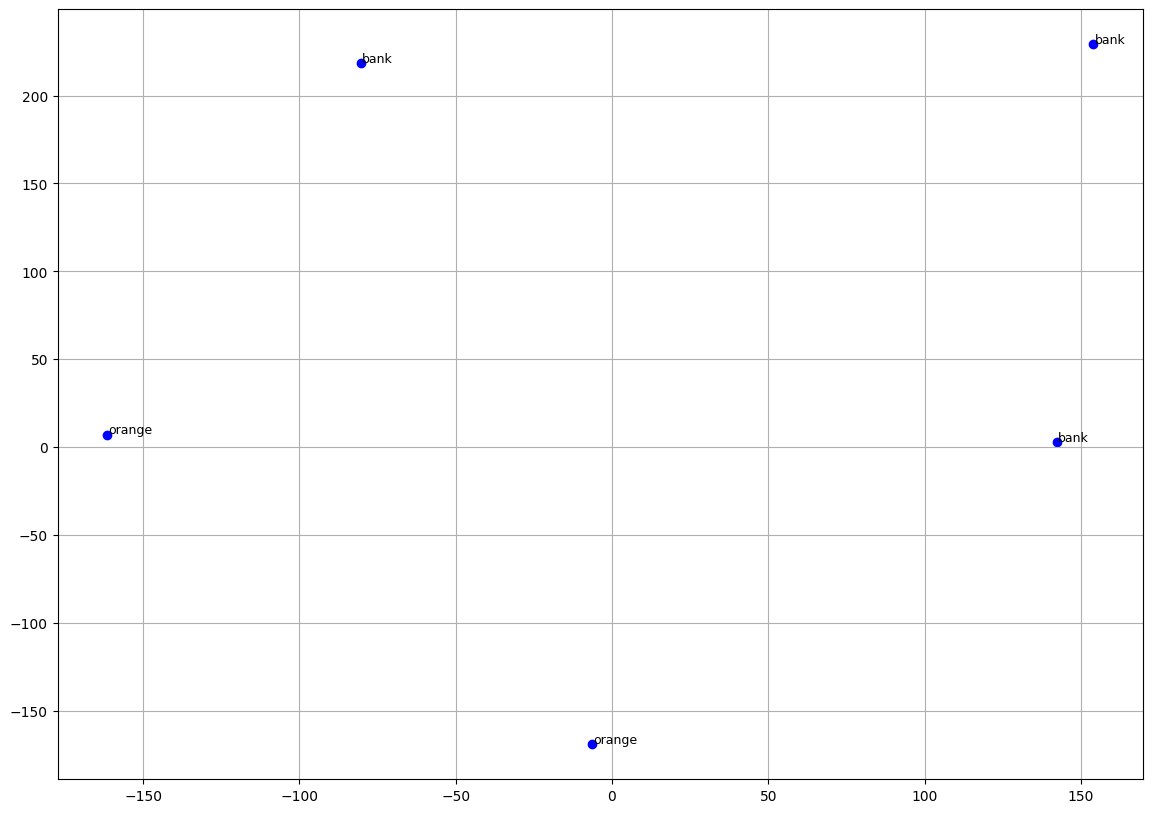

In [23]:
import matplotlib.pyplot as plt

# Étape 2 : Visualisation
plt.figure(figsize=(14, 10))
words = [w for token in tokens for w in token if w == 'orange' or w == 'bank']

for i, word in enumerate(words):
    x, y= reduced_embeddings[i, 0], reduced_embeddings[i, 1]
    plt.scatter(x, y, color='blue')  # Dessine le point
    plt.text(x + 0.5, y + 0.5, word, fontsize=9)  # Annoter le mot

plt.grid(True)
plt.show()
